Ref: https://github.com/PacktPublishing/Python-for-Finance-Cookbook/tree/master/Chapter%2010

# Tabular Classification

In [1]:
# Load Data
from fastai import *
from fastai.tabular import *
import pandas as pd
import numpy as np

df = pd.read_csv("https://raw.githubusercontent.com/PacktPublishing/Python-for-Finance-Cookbook/master/Datasets/credit_card_default.csv", index_col=0, na_values='')
df

,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24.0,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,Unknown,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26.0,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,Payment delayed 2 months,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,University,Married,57.0,Payed duly,Unknown,Payed duly,Unknown,Unknown,Unknown,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,NaN,High school,Married,39.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,Male,High school,Single,43.0,Payed duly,Payed duly,Payed duly,Payed duly,Unknown,Unknown,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,Male,University,Single,37.0,Payment delayed 4 months,Payment delayed 3 months,Payment delayed 2 months,Payed duly,Unknown,Unknown,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,Male,High school,Married,41.0,Payment delayed 1 month,Payed duly,Unknown,Unknown,Unknown,Payed duly,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [2]:
# Identify target and features
DEP_VAR = 'default_payment_next_month'

num_features = list(df.select_dtypes('number').columns)
num_features.remove(DEP_VAR)
cat_features = list(df.select_dtypes('object').columns)

# list of preprocessing
preprocessing = [FillMissing, Categorify, Normalize]

In [3]:
# Create dataframe
data = (TabularList.from_df(df, 
                            cat_names=cat_features,
                            cont_names=num_features, 
                            procs=preprocessing)
                   .split_by_rand_pct(valid_pct=0.2, seed=42)
                   .label_from_df(cols=DEP_VAR)
                   .databunch())
data

TabularDataBunch;

Train: LabelList (24000 items)
x: TabularList
sex Female; education University; marriage Married; payment_status_sep Payment delayed 2 months; payment_status_aug Payment delayed 2 months; payment_status_jul Payed duly; payment_status_jun Payed duly; payment_status_may Unknown; payment_status_apr Unknown; age_na False; limit_bal -1.1348; age -1.2474; bill_statement_sep -0.6405; bill_statement_aug -0.6459; bill_statement_jul -0.6651; bill_statement_jun -0.6714; bill_statement_may -0.6622; bill_statement_apr -0.6539; previous_payment_sep -0.3319; previous_payment_aug -0.2171; previous_payment_jul -0.2882; previous_payment_jun -0.2994; previous_payment_may -0.3085; previous_payment_apr -0.2955; ,sex Female; education University; marriage Single; payment_status_sep Payed duly; payment_status_aug Payment delayed 2 months; payment_status_jul Unknown; payment_status_jun Unknown; payment_status_may Unknown; payment_status_apr Payment delayed 2 months; age_na False; limit_bal 

epoch,train_loss,valid_loss,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03
Min loss divided by 10: 3.31E-05


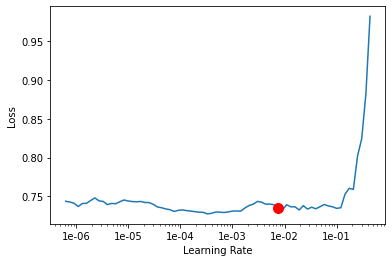

epoch,train_loss,valid_loss,recall,f_beta,f_beta,time
0,0.684715,0.656842,0.583397,0.385797,0.561283,00:19
1,0.678590,0.652812,0.583397,0.392619,0.562376,00:09
2,0.671350,0.646393,0.600914,0.404304,0.579246,00:11
3,0.660906,0.639132,0.536938,0.395290,0.522535,00:08
4,0.662786,0.625267,0.448591,0.380123,0.442460,00:08
5,0.658744,0.622888,0.517898,0.405486,0.507084,00:08
6,0.656318,0.628724,0.518660,0.398013,0.506841,00:08
7,0.652718,0.623294,0.495050,0.395257,0.485618,00:08
8,0.649660,0.622728,0.507997,0.407826,0.498577,00:08
9,0.646614,0.611556,0.405179,0.381636,0.403265,00:08


In [4]:
# Define Neural Net Learner
learn = tabular_learner(data, layers=[1000,500], 
                        ps=[0.001,0.01], 
                        emb_drop=0.04, 
                        metrics=[Recall(), 
                                 FBeta(beta=1),
                                 FBeta(beta=5)])

# Find Learning Rate
learn.lr_find()
learn.recorder.plot(suggestion=True)
plt.show()

# Train Model
learn.fit(epochs=25, lr=1e-6, wd=0.2)

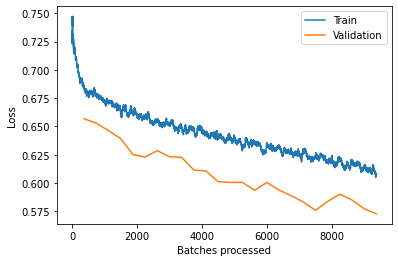

In [5]:
# Plot Loss
learn.recorder.plot_losses()
plt.show()

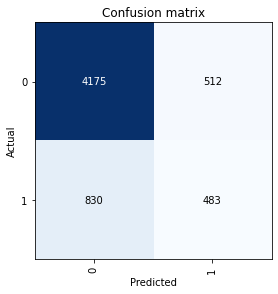

,Prediction,Actual,Loss,Probability,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr
0,0,1,3.88,0.02,Male,school,Single,duly,duly,duly,duly,duly,duly,False,0.8693,-0.2704,-0.6816,-0.6770,-0.6704,-0.6573,-0.6568,-6.3825,-0.2794,-0.2321,-0.2390,-0.2794,-0.3085,19.4823
1,1,0,2.50,0.08,Male,school,Married,Unknown,Unknown,Unknown,duly,Unknown,Unknown,False,3.2587,2.9862,7.8954,8.4296,9.3319,4.3938,5.2547,5.5822,1.3070,2.2712,17.5272,2.1539,0.9719,2.6257
2,0,1,1.59,0.20,Female,school,Married,Unknown,Unknown,Unknown,Unknown,duly,duly,False,1.7942,-0.8132,1.7745,0.5322,0.2230,-0.0783,-0.6597,-0.6506,-0.0978,-0.1631,-0.2334,-0.2902,-0.2962,-0.0842
3,0,1,1.58,0.21,Female,school,Married,Unknown,duly,duly,duly,duly,duly,False,1.4088,-0.2704,0.4365,0.2766,-0.4162,-0.3909,-0.1552,-0.1295,3.7033,0.4965,0.7016,1.5956,1.6918,4.7714
4,1,0,1.55,0.21,Male,school,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,1.9484,-0.1618,5.4967,5.8922,6.3022,6.8174,7.4057,7.5982,0.8387,0.7428,0.3147,0.3140,-0.3085,0.3345


In [6]:
# Evaluate for validation dataset
preds_valid, _ = learn.get_preds(ds_type=DatasetType.Valid)
pred_valid = preds_valid.argmax(dim=-1)

# Evaluate Performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
plt.show()

interp.plot_tab_top_losses(5)

# Time Series Forecasting

## Data Preparation

In [7]:
!pip install yfinance

1.10.0+cu111


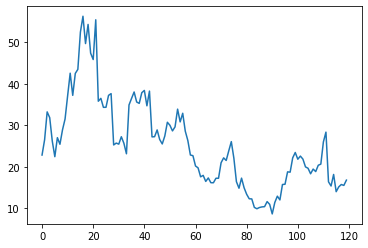

In [18]:
# Load Data

import yfinance as yf
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, 
                              DataLoader, Subset)

from sklearn.metrics import mean_squared_error

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# data
TICKER = 'ANF'
START_DATE = '2010-01-02'
END_DATE = '2019-12-31'
N_LAGS = 12

# neural network 
VALID_SIZE = 12
BATCH_SIZE = 5
N_EPOCHS = 200 #1000

df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('M').last()
prices = df['Adj Close'].values

plt.plot(prices)

In [19]:
# Convert Data to Tensor

def create_input_data(series, n_lags=1):
    '''
    Function for transforming time series into input acceptable by a multilayer perceptron.
    
    Parameters
    ----------
    series : np.array
        The time series to be transformed
    n_lags : int
        The number of lagged observations to consider as features

    Returns
    -------
    X : np.array
        Array of features
    y : np.array
        Array of target
    '''
    X, y = [], []

    for step in range(len(series) - n_lags):
        end_step = step + n_lags
        X.append(series[step:end_step])
        y.append(series[end_step])
    return np.array(X), np.array(y)

X, y = create_input_data(prices, N_LAGS)

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

# Create Loader
valid_ind = len(X) - VALID_SIZE

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE) 

## Naive Prediction

In [20]:
# Benchmark Naive Prediction
naive_pred = prices[len(prices) - VALID_SIZE - 1:-1]
y_valid = prices[len(prices) - VALID_SIZE:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 17.37, RMSE: 4.17


## Multi-Layer Perceptron

In [21]:
# Define Neural Network
class MLP(nn.Module):
   
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_size, 12)
        self.linear2 = nn.Linear(12, 4)
        self.linear3 = nn.Linear(4, 1)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x

# set seed for reproducibility
torch.manual_seed(42)

model = MLP(N_LAGS).to(device) 
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
PRINT_EVERY = 50
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = loss_fn(y_batch, y_hat)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        
        model.eval()
        
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = loss_fn(y_val, y_hat)
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './mlp_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 702.73 	 Valid. loss: 283.57
<50> - Train. loss: 107.49 	 Valid. loss: 21.98
<100> - Train. loss: 112.30 	 Valid. loss: 29.39
<150> - Train. loss: 125.10 	 Valid. loss: 23.85
Lowest loss recorded in epoch: 9


In [22]:
# Evaluate
state_dict = torch.load('mlp_checkpoint.pth')
model.load_state_dict(state_dict)

y_pred, y_valid= [], []

with torch.no_grad():

    model.eval()
    
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)    
        y_pred.append(model(x_val))
        y_valid.append(y_val)
        
y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

mlp_mse = mean_squared_error(y_valid, y_pred)
mlp_rmse = np.sqrt(mlp_mse)
print(f"MLP's forecast - MSE: {mlp_mse:.2f}, RMSE: {mlp_rmse:.2f}")

MLP's forecast - MSE: 18.67, RMSE: 4.32


## CNN

In [23]:
# Define CNN

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

model = nn.Sequential(OrderedDict([
    ('conv_1', nn.Conv1d(1, 32, 3, padding=1)),
    ('max_pool_1', nn.MaxPool1d(2)),
    ('relu_1', nn.ReLU()),
    ('flatten', Flatten()),
    ('fc_1', nn.Linear(192, 50)),
    ('relu_2', nn.ReLU()),
    ('dropout_1', nn.Dropout(0.4)),
    ('fc_2', nn.Linear(50, 1))
]))

print(model)

model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train CNN
PRINT_EVERY = 50
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        x_batch = x_batch.view(x_batch.shape[0], 1, N_LAGS)
        y_batch = y_batch.to(device)
        y_batch = y_batch.view(y_batch.shape[0], 1, 1)
        y_hat = model(x_batch).view(y_batch.shape[0], 1, 1)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
            y_val = y_val.to(device)
            y_val = y_val.view(y_val.shape[0], 1, 1)
            y_hat = model(x_val).view(y_val.shape[0], 1, 1)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './cnn_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.6f} \t Valid. loss: {epoch_loss_valid:.6f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

Sequential(
  (conv_1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (flatten): Flatten()
  (fc_1): Linear(in_features=192, out_features=50, bias=True)
  (relu_2): ReLU()
  (dropout_1): Dropout(p=0.4, inplace=False)
  (fc_2): Linear(in_features=50, out_features=1, bias=True)
)
<0> - Train. loss: 14.521913 	 Valid. loss: 6.024386
<50> - Train. loss: 5.891373 	 Valid. loss: 4.508741
<100> - Train. loss: 6.438412 	 Valid. loss: 4.286388
<150> - Train. loss: 6.304438 	 Valid. loss: 4.349677
Lowest loss recorded in epoch: 2


In [24]:
# Evaluate
state_dict = torch.load('cnn_checkpoint.pth')
model.load_state_dict(state_dict)

y_pred, y_valid = [], []

with torch.no_grad():
    
    model.eval()
        
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
        y_pred.append(model(x_val))
        y_valid.append(y_val)
        
y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

mlp_mse = mean_squared_error(y_valid, y_pred)
mlp_rmse = np.sqrt(mlp_mse)
print(f"CNN's forecast - MSE: {mlp_mse:.2f}, RMSE: {mlp_rmse:.2f}")

CNN's forecast - MSE: 19.14, RMSE: 4.37


## RNN

In [25]:
# Create Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, 
                          n_layers, batch_first=True,
                          nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc(output[:,-1,:]) 
        return output

model = RNN(input_size=1, hidden_size=6, 
            n_layers=1, output_size=1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
PRINT_EVERY = 10
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)[:, :, None]
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)[:, :, None]
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './rnn_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.4f} \t Valid. loss: {epoch_loss_valid:.4f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 25.5478 	 Valid. loss: 18.3735
<10> - Train. loss: 25.3490 	 Valid. loss: 18.1754
<20> - Train. loss: 25.1503 	 Valid. loss: 17.9774
<30> - Train. loss: 24.9517 	 Valid. loss: 17.7794
<40> - Train. loss: 24.7531 	 Valid. loss: 17.5814
<50> - Train. loss: 24.5545 	 Valid. loss: 17.3835
<60> - Train. loss: 24.3560 	 Valid. loss: 17.1857
<70> - Train. loss: 24.1575 	 Valid. loss: 16.9879
<80> - Train. loss: 23.9590 	 Valid. loss: 16.7902
<90> - Train. loss: 23.7606 	 Valid. loss: 16.5925
<100> - Train. loss: 23.5622 	 Valid. loss: 16.3949
<110> - Train. loss: 23.3639 	 Valid. loss: 16.1974
<120> - Train. loss: 23.1656 	 Valid. loss: 15.9999
<130> - Train. loss: 22.9673 	 Valid. loss: 15.8024
<140> - Train. loss: 22.7691 	 Valid. loss: 15.6051
<150> - Train. loss: 22.5710 	 Valid. loss: 15.4077
<160> - Train. loss: 22.3728 	 Valid. loss: 15.2105
<170> - Train. loss: 22.1748 	 Valid. loss: 15.0133
<180> - Train. loss: 21.9768 	 Valid. loss: 14.8162
<190> - Train. loss: 21

In [26]:
# Evaluate
state_dict = torch.load('rnn_checkpoint.pth')
model.load_state_dict(state_dict)

y_pred = []

with torch.no_grad():
    
    model.eval()
    
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)[:, :, None]
        y_hat = model(x_val)
        y_pred.append(y_hat)
        
y_pred = torch.cat(y_pred).numpy().flatten()
# y_pred = minmax.inverse_transform(y_pred).flatten()

mlp_mse = mean_squared_error(y_valid, y_pred)
mlp_rmse = np.sqrt(mlp_mse)
print(f"CNN's forecast - MSE: {mlp_mse:.2f}, RMSE: {mlp_rmse:.2f}")

CNN's forecast - MSE: 220.35, RMSE: 14.84
